In [1]:
# cell 1: imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 50)
sns.set(style='whitegrid')


In [2]:
# cell 2: load the data
housing = pd.read_csv("housing.csv")
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# cell 3: quick info & stats
housing.info()
housing.describe()
housing['ocean_proximity'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

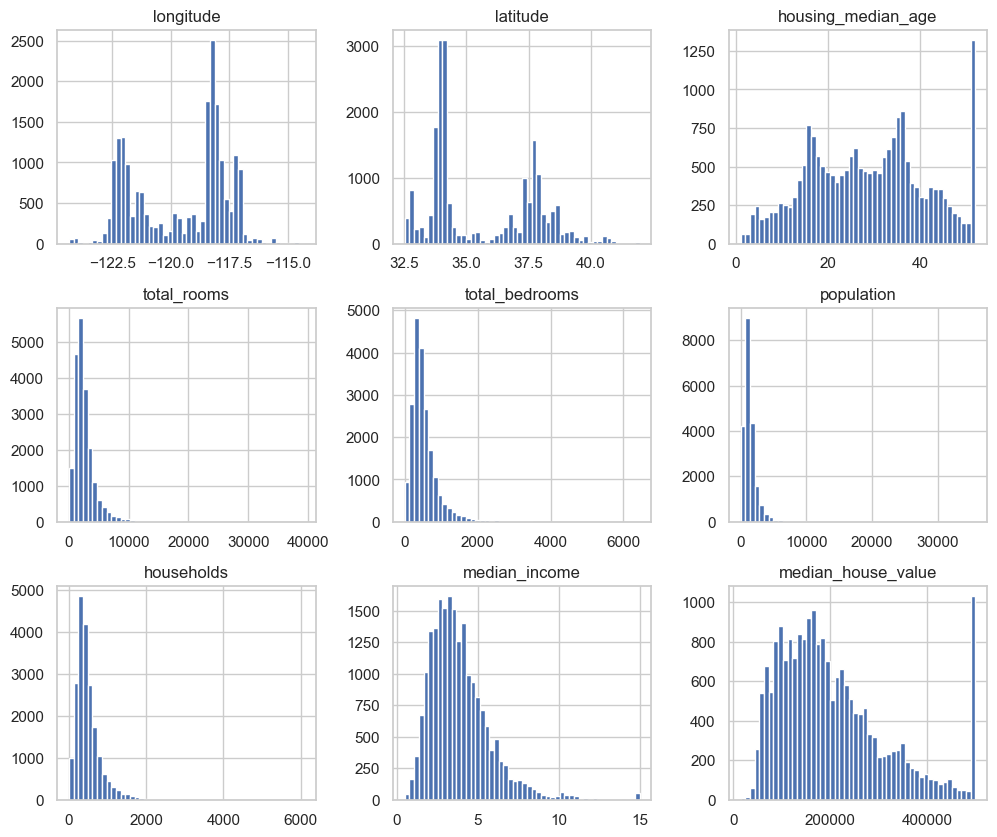

In [4]:
# histograms
housing.hist(bins=50, figsize=(12,10))
plt.show()


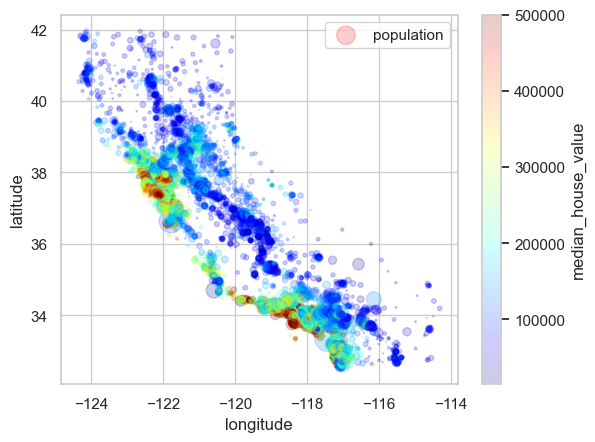

In [5]:
# geography scatter (longitude vs latitude)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2,
             s=housing["population"]/100, label="population", 
             c="median_house_value", cmap="jet", colorbar=True)
plt.legend()
plt.show()


We can note that houses near the cost or around LA/SF area generally have higher prices ...

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)


(16512, 4128)

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


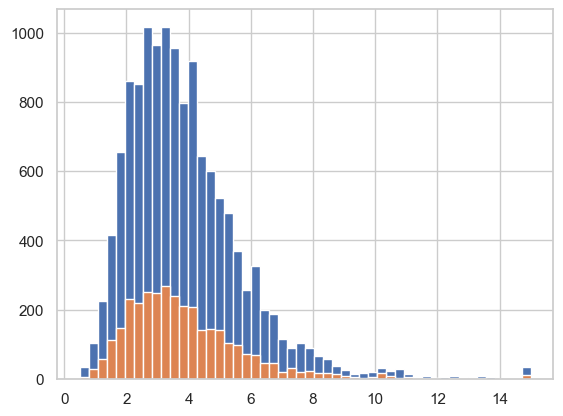

In [8]:
housing = train_set.copy()  # use copy for exploration so original train_set kept intact

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_idx].drop("income_cat", axis=1)
    strat_val_set = housing.iloc[val_idx].drop("income_cat", axis=1)

# sanity check distribution
print(strat_train_set["median_income"].hist(bins=50))
print(strat_val_set["median_income"].hist(bins=50))


In [9]:
# Separate features and target
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Handle text attribute 'ocean_proximity' using one-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Separate numerical and categorical columns
num_attribs = list(housing.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

# Create a preprocessing pipeline
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)


Baseline RMSE to compare models against 

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Separate features and target
housing = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

# Baseline: always predict the mean house value
baseline_pred = np.full(len(y_train), y_train.mean())

# Compute baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_train, baseline_pred))

print("Baseline RMSE (mean predictor):", baseline_rmse)


Baseline RMSE (mean predictor): 115429.71228010787


In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Linear Regression RMSE:", lin_rmse)


Linear Regression RMSE: 68189.67799557638


we can note that the RMSE is 68189 which is very high compared to the median so we underfit the data, a simple Linear Regression model is too basic to predict prices ...


In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, y_train)

y_pred_tree = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(y_train, y_pred_tree))
print("Decision Tree RMSE (training):", tree_rmse)


Decision Tree RMSE (training): 0.0


RMSE being 0.0 indicates the decision tree has overfit the data (learnt it too well) and is an unreliable model as well

In [17]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, y_train)

y_pred_forest = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(y_train, y_pred_forest))
print("Random Forest RMSE (training):", forest_rmse)


Random Forest RMSE (training): 18661.837121996694


Best outputs yet we chose this model and fine tune for optimal results.

In [21]:
strat_val_set_prepared = full_pipeline.transform(strat_val_set)


In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

val_predictions = forest_reg.predict(strat_val_set_prepared)
val_labels = strat_val_set["median_house_value"]

val_rmse = np.sqrt(mean_squared_error(val_labels, val_predictions))
print("Validation RMSE (before tuning):", val_rmse)


Validation RMSE (before tuning): 48025.17648381843


In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]

strat_train_set_prepared = full_pipeline.transform(housing)


In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50, 100, 200],
     'max_features': [6, 8, 10],
     'max_depth': [10, 20, None]}
]

grid_search = GridSearchCV(forest_reg, param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(strat_train_set_prepared, strat_train_set["median_house_value"])


,estimator,RandomForestR...ndom_state=42)
,param_grid,"[{'max_depth': [10, 20, ...], 'max_features': [6, 8, ...], 'n_estimators': [50, 100, ...]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,200


In [27]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best parameters: {'max_depth': None, 'max_features': 6, 'n_estimators': 200}


In [28]:
val_features = full_pipeline.transform(strat_val_set.drop("median_house_value", axis=1))
val_labels = strat_val_set["median_house_value"]

val_predictions = best_model.predict(val_features)
val_rmse = np.sqrt(mean_squared_error(val_labels, val_predictions))
print("Validation RMSE (after tuning):", val_rmse)


Validation RMSE (after tuning): 47043.157809156924


In [29]:
feature_importances = best_model.feature_importances_
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.get_feature_names_out())

attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(np.float64(0.42462671944032054), 'median_income'),
 (np.float64(0.14334027342638245), 'population_per_household'),
 (np.float64(0.11628303566794758), 'longitude'),
 (np.float64(0.10603340815502363), 'latitude'),
 (np.float64(0.04841309263148), 'housing_median_age'),
 (np.float64(0.043826002050905005), 'population'),
 (np.float64(0.03414878821183095), 'total_rooms'),
 (np.float64(0.030469942767079424), 'total_bedrooms'),
 (np.float64(0.027469614461195058), 'households'),
 (np.float64(0.014743913808288519), 'rooms_per_household'),
 (np.float64(0.0063635589131016065), 'ocean_proximity_INLAND'),
 (np.float64(0.003977146267595553), 'ocean_proximity_<1H OCEAN'),
 (np.float64(0.0003045041988494757), 'bedrooms_per_room')]